# Módulo 27 - PCA

### Tarefa 01: *HAR* com PCA

Luciana Gonzaga

---

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [2]:
filename_features = "./Dados/UCI HAR Dataset/features.txt"
filename_labels = "./Dados/UCI HAR Dataset/activity_labels.txt"

filename_subtrain = "./Dados/UCI HAR Dataset/train/subject_train.txt"
filename_xtrain = "./Dados/UCI HAR Dataset/train/X_train.txt"
filename_ytrain = "./Dados/UCI HAR Dataset/train/y_train.txt"

filename_subtest = "./Dados/UCI HAR Dataset/test/subject_test.txt"
ffilename_xtest = "./Dados/UCI HAR Dataset/test/X_test.txt"
filename_ytest = "./Dados/UCI HAR Dataset/test/y_test.txt"

features = pd.read_csv(filename_features, header=None, names=['nome_var'], squeeze=True, sep="#")
labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'], squeeze=True)
X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.tolist())
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'], squeeze=True)
X_test = pd.read_csv(ffilename_xtest, delim_whitespace=True, header=None, names=features.tolist())
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

C:\Users\windows 10 Pro 2022\AppData\Local\Temp\ipykernel_15144\465872272.py:12: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  features = pd.read_csv(filename_features, header=None, names=['nome_var'], squeeze=True, sep="#")
C:\Users\windows 10 Pro 2022\AppData\Local\Temp\ipykernel_15144\465872272.py:15: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'], squeeze=True)
C:\Users\windows 10 Pro 2022\AppData\Local\Temp\ipykernel_15144\465872272.py:19: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'], squeeze=True)


## Árvore de decisão

Rode uma árvore de decisão com todas as variáveis, utilizando o ```ccp_alpha=0.001```. Avalie a acurácia nas bases de treinamento e teste. Avalie o tempo de processamento.

In [3]:
%%time
clf = DecisionTreeClassifier(random_state=42, ccp_alpha=0.001)

clf.fit(X_train, y_train)

CPU times: total: 7.02 s
Wall time: 7.11 s


DecisionTreeClassifier(ccp_alpha=0.001, random_state=42)

In [4]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

cv_scores = cross_val_score(clf, X_train, y_train, cv=5)

print(f'Acurácia na base de treinamento: {train_accuracy:.2f}')
print(f'Acurácia na base de teste: {test_accuracy:.2f}')
print(f'Acurácia média na validacão cruzada: {cv_scores.mean():.2f}\n')

Acurácia na base de treinamento: 0.98
Acurácia na base de teste: 0.88
Acurácia média na validacão cruzada: 0.86



## Árvore com PCA

Faça uma análise de componemtes principais das variáveis originais. Utilize apenas uma componente. Faça uma árvore de decisão com esta componente como variável explicativa.

- Avalie a acurácia nas bases de treinamento e teste
- Avalie o tempo de processamento

#### *Construindo o modelo com PCA:*

In [5]:
%%time
prcomp = PCA(n_components=1).fit(X_train)

pc_treino = prcomp.transform(X_train)
pc_teste  = prcomp.transform(X_test)

pc_treino.shape

CPU times: total: 609 ms
Wall time: 371 ms


(7352, 1)

In [6]:
n=1

colunas = ['cp'+str(x+1) for x in list(range(n))]

pc_train = pd.DataFrame(pc_treino[:,:n], columns = colunas)
pc_test  = pd.DataFrame( pc_teste[:,:n], columns = colunas)

pc_train.head()

,cp1
0,-5.520280
1,-5.535350
2,-5.474988
3,-5.677232
4,-5.748749


#### *Treinando o modelo:*

In [7]:
%%time
clf = DecisionTreeClassifier(random_state=1234).fit(pc_train, y_train)

caminho = DecisionTreeClassifier(random_state=2360873, min_samples_leaf=20).cost_complexity_pruning_path(pc_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(pc_train, y_train)
    clfs.append(clf)

CPU times: total: 9.41 s
Wall time: 9.39 s


#### *Avaliando a acurácia do modelo:*

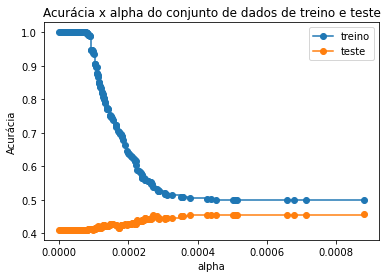

In [8]:
train_scores = [clf.score(pc_train, y_train) for clf in clfs]
test_scores = [clf.score(pc_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e teste")
nx=-10
ax.plot(ccp_alphas[:nx], train_scores[:nx], marker='o', label="treino",    drawstyle="steps-post")
ax.plot(ccp_alphas[:nx], test_scores[:nx], marker='o', label="teste", drawstyle="steps-post")

ax.legend()
plt.show()

In [9]:
ind_melhor_arvore = len(test_scores) - test_scores[::-1].index(max(test_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

acc_train = train_scores[ind_melhor_arvore]
acc_teste = melhor_arvore.score(pc_test, y_test)

cv_scores = cross_val_score(melhor_arvore, pc_train, y_train, cv=5)

print(f'Acurácia da melhor árvore na base de treino:    {acc_train*100:.1f}')
print(f'Acurácia da melhor árvore na base de teste:     {acc_teste*100:.1f}')
print(f'Acurácia média na validacão cruzada: {cv_scores.mean()*100:.1f}')

Acurácia da melhor árvore na base de treino:    49.5
Acurácia da melhor árvore na base de teste:     46.9
Acurácia média na validacão cruzada: 46.9


## Testando o número de componentes

Com base no código acima, teste a árvore de classificação com pelo menos as seguintes possibilidades de quantidades de componentes: ```[1, 2, 5, 10, 50]```. Avalie para cada uma delas:

- Acurácia nas bases de treino e teste
- Tempo de processamento


In [10]:
%%time
grid = [1, 2, 5, 10, 20, 30, 50, 70]

for n in grid:
        
    prcomp = PCA(n_components=n).fit(X_train)
    pc_treino = prcomp.transform(X_train)
    pc_teste  = prcomp.transform(X_test)
    
    colunas = ['cp'+str(x+1) for x in list(range(n))]
    pc_train = pd.DataFrame(pc_treino[:,:n], columns = colunas)
    pc_test  = pd.DataFrame( pc_teste[:,:n], columns = colunas)
    
    
    inicio = time.time()
    clf = DecisionTreeClassifier(random_state=1234).fit(pc_train, y_train)
    caminho = DecisionTreeClassifier(random_state=2360873, min_samples_leaf=20).cost_complexity_pruning_path(pc_train, y_train)
    ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities
    ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])
    clfs = []
    for ccp_alpha in ccp_alphas:
        clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(pc_train, y_train)
        clfs.append(clf)
    fim = time.time()
        
    train_scores = [clf.score(pc_train, y_train) for clf in clfs]
    test_scores = [clf.score(pc_test, y_test) for clf in clfs]
    ind_melhor_arvore = len(test_scores) - test_scores[::-1].index(max(test_scores)) - 1
    melhor_arvore = clfs[ind_melhor_arvore]
    acc_train = train_scores[ind_melhor_arvore]
    acc_teste = melhor_arvore.score(pc_test, y_test)
    cv_scores = cross_val_score(melhor_arvore, pc_train, y_train, cv=5)

    print(f'Número de componentes: {n}')
    print(f'Acurácia da melhor árvore na base de treino:    {acc_train*100:.1f}')
    print(f'Acurácia da melhor árvore na base de teste:     {acc_teste*100:.1f}')
    print(f'Acurácia média na validacão cruzada: {cv_scores.mean()*100:.1f}')
    print(f'Tempo de processamento: {fim-inicio:.2f} s\n')
    

Número de componentes: 1
Acurácia da melhor árvore na base de treino:    49.5
Acurácia da melhor árvore na base de teste:     46.9
Acurácia média na validacão cruzada: 46.9
Tempo de processamento: 7.90 s

Número de componentes: 2
Acurácia da melhor árvore na base de treino:    60.4
Acurácia da melhor árvore na base de teste:     59.2
Acurácia média na validacão cruzada: 56.7
Tempo de processamento: 9.26 s

Número de componentes: 5
Acurácia da melhor árvore na base de treino:    83.9
Acurácia da melhor árvore na base de teste:     79.1
Acurácia média na validacão cruzada: 75.0
Tempo de processamento: 8.19 s

Número de componentes: 10
Acurácia da melhor árvore na base de treino:    90.5
Acurácia da melhor árvore na base de teste:     82.7
Acurácia média na validacão cruzada: 80.5
Tempo de processamento: 14.37 s

Número de componentes: 20
Acurácia da melhor árvore na base de treino:    91.9
Acurácia da melhor árvore na base de teste:     82.6
Acurácia média na validacão cruzada: 78.7
Temp

## Conclua

O que aconteceu com a acurácia?

O que aconteceu com o tempo de processamento?

- Quanto mais componentes maior é o tempo de processamento.
- A acurácia aumentou conforme aumentou-se o número de componentes. Porém, a partir de 10 componentes, a acurácia de validação diminuiu um pouco.